In [1]:
import geopandas as gpd
import pandas as pd
import os
import requests

In [ ]:
url = "https://api.carbonintensity.org.uk/regional"
path_to_data = os.path.join("..","data","geo")

In [57]:
! ls {path_to_data}

carbon_intensity_regional.png		uk_dno_regions_2024.geojson
national_grid_dno_regions_2024.geojson


In [3]:
def get_api_regional_response():
    url = "https://api.carbonintensity.org.uk/regional"
    response = requests.get(url).json()
    # print(response)
    regions = response['data'][0]['regions']
    return regions

In [4]:
def regional_response_to_df(regions):
    """
        parse API response into desired df, with columns:
        'id', 'dno_region', 'api_name', 'intensity_forecast', 'intensity_index',
       'biomass_perc', 'coal_perc', 'imports_perc', 'gas_perc', 'nuclear_perc',
       'other_perc', 'hydro_perc', 'solar_perc', 'wind_perc'
    """
    # regions = response_regional['data'][0]['regions']

    rows = []
    for region in regions:
        region_id = region["regionid"]
        dno_region = region["dnoregion"]
        name = region["shortname"]
        intensity_forecast = region["intensity"]["forecast"]
        intensity_index = region["intensity"]["index"]

        row_dict = {
            "id" : region_id,
            "dno_region" : dno_region,
            "api_name" : name,
            "carbon_intensity_forecast" : intensity_forecast,
            "carbon_intensity_index" : intensity_index
        }

        for fuel in region["generationmix"]:
            fuel_name = fuel["fuel"]
            fuel_percentage = fuel["perc"]
            row_dict[fuel_name+"_perc"] = fuel_percentage

        rows.append(row_dict)

    return pd.DataFrame(rows)

def get_api_regions_as_df():
    regions = get_api_regional_response()
    regions_df = regional_response_to_df(regions)
    return regions_df

In [5]:
def process_local_geojson(filename_in = "national_grid_dno_regions_2024.geojson", filename_out="uk_dno_regions_2024.geojson"):
    """
        rename the IDs from downloaded geojson file with IDs as served by API
    """
    # filename = "national_grid_dno_regions_2024.geojson"
    path_to_data = os.path.join("data")
    filepath_in = os.path.join(path_to_data, filename_in)
    filepath_out = os.path.join(path_to_data, filename_out)
    print(f"processing file: {filepath_in}")
    
    # Read the GeoJSON file
    uk_regions_2024 = gpd.read_file(filepath_in)

    #rename some areas so we can sort alphabetically and match api region id to region ids from file
    rename_geojson_areas_to_api = {"Southern England":  "South England", "South and Central Scotland" : "South Scotland"}
    uk_regions_2024["Area"] = uk_regions_2024["Area"].map(lambda x: rename_geojson_areas_to_api.get(x,x) )

    #get sample api response to lineup the ids
    region_response_df = get_api_regions_as_df()

    #line up the ids from file + api
    lineup_file_df = uk_regions_2024.sort_values(by="Area").rename(columns={"ID" : "geojson_id", "Area" : "geojson_name"}).reset_index(drop=True)
    lineup_api_df = region_response_df.iloc[:14, :3].sort_values(by="api_name").rename(columns={"id":"api_id"}).reset_index(drop=True)
    lineup_df = pd.concat([lineup_file_df,lineup_api_df], axis=1)[["geojson_id","api_id", "geojson_name", "api_name"]]
    #create id mapping dict thanks to lineup_df
    id_map_dict = {}
    for geo_id, api_id,api_name in zip(lineup_df.geojson_id, lineup_df.api_id,lineup_df.api_name):
        print(f"Region: {api_name}. Geojson id: {geo_id} -> Api_id: {api_id}" )
        id_map_dict[geo_id] = [api_id, api_name]

    #execute the mapping of IDs
    uk_regions_2024["ID"] = uk_regions_2024["ID"].map(lambda id : id_map_dict[id][0])

    #sort by ID before save, for sanity
    uk_regions_2024 = uk_regions_2024.sort_values(by="ID")
    
    print(f"saving processed file to: {filepath_out}")
    uk_regions_2024.to_file(filepath_out)
    return uk_regions_2024
# process_local_geojson()
# uk_reg = process_local_geojson()

# plot the geo

In [6]:
! ls ..

api   Dockerfile  links.txt  notebooks	requirements_prod.txt  todo.txt
data  ideas.txt   Makefile   README.md	requirements.txt


In [7]:
import os
import matplotlib.pyplot as plt

In [8]:
path_to_data = os.path.join("..","data", "geo")
geojson_filename = "uk_dno_regions_2024.geojson"
filepath = os.path.join(path_to_data, geojson_filename)

uk_regions = gpd.read_file(filepath)

In [9]:
uk_regions.head(3)

ID Name   DNO                Area  \
0   1   _P  SSEN      North Scotland   
1   2   _N  SPEN      South Scotland   
2   3   _G  ENWL  North West England   

                                     DNO_Full  \
0  Scottish and Southern Electricity Networks   
1                          SP Energy Networks   
2                      Electricity North West   

                                            geometry  
0  MULTIPOLYGON (((201985.002 598540.625, 201777....  
1  MULTIPOLYGON (((225860 533350, 225930 533330, ...  
2  MULTIPOLYGON (((357929 583757, 358217 582616, ...

In [10]:
uk_live_df = get_api_regions_as_df()
uk_live_df.head(3)

id                                  dno_region            api_name  \
0   1  Scottish Hydro Electric Power Distribution      North Scotland   
1   2                             SP Distribution      South Scotland   
2   3                      Electricity North West  North West England   

   carbon_intensity_forecast carbon_intensity_index  biomass_perc  coal_perc  \
0                         14               very low           0.0          0   
1                         17               very low           2.6          0   
2                         30               very low           1.4          0   

   imports_perc  gas_perc  nuclear_perc  other_perc  hydro_perc  solar_perc  \
0           0.0       3.5           0.1           0        24.8           0   
1           2.3       3.4          28.6           0         1.1           0   
2           8.2       7.0          47.1           0         0.1           0   

   wind_perc  
0       71.6  
1       62.0  
2       36.1

In [11]:
uk_live_to_join = uk_live_df[["id","api_name","dno_region","carbon_intensity_forecast", "carbon_intensity_index"]]
uk_live_to_join

id                  api_name                                  dno_region  \
0    1            North Scotland  Scottish Hydro Electric Power Distribution   
1    2            South Scotland                             SP Distribution   
2    3        North West England                      Electricity North West   
3    4        North East England                              NPG North East   
4    5                 Yorkshire                               NPG Yorkshire   
5    6  North Wales & Merseyside                                   SP Manweb   
6    7               South Wales                             WPD South Wales   
7    8             West Midlands                           WPD West Midlands   
8    9             East Midlands                           WPD East Midlands   
9   10              East England                                   UKPN East   
10  11        South West England                              WPD South West   
11  12             South England                                   SSE South   
12  13                    London                                 UKPN London   
13  14        South East England                             UKPN South East   
14  15                   England                                     England   
15  16                  Scotland                                    Scotland   
16  17                     Wales                                       Wales   
17  18                        GB                                          GB   

    carbon_intensity_forecast carbon_intensity_index  
0                          14               very low  
1                          17               very low  
2                          30               very low  
3                          15               very low  
4                          94                    low  
5                          31               very low  
6                         181               moderate  
7                          61                    low  
8                         160               moderate  
9                          54                    low  
10                        237                   high  
11                        110               moderate  
12                         77                    low  
13                         98                    low  
14                         69                    low  
15                         19               very low  
16                        109                    low  
17                         74                    low

In [12]:
uk_regions.merge(uk_live_to_join, how="inner", left_on="ID", right_on="id").head()

ID Name   DNO                Area  \
0   1   _P  SSEN      North Scotland   
1   2   _N  SPEN      South Scotland   
2   3   _G  ENWL  North West England   
3   4   _F   NPG  North East England   
4   5   _M   NPG           Yorkshire   

                                     DNO_Full  \
0  Scottish and Southern Electricity Networks   
1                          SP Energy Networks   
2                      Electricity North West   
3                          Northern Powergrid   
4                          Northern Powergrid   

                                            geometry  id            api_name  \
0  MULTIPOLYGON (((201985.002 598540.625, 201777....   1      North Scotland   
1  MULTIPOLYGON (((225860 533350, 225930 533330, ...   2      South Scotland   
2  MULTIPOLYGON (((357929 583757, 358217 582616, ...   3  North West England   
3  MULTIPOLYGON (((425411 637102, 425373 637102, ...   4  North East England   
4  MULTIPOLYGON (((385706 483951, 386005 483869, ...   5           Yorkshire   

                                   dno_region  carbon_intensity_forecast  \
0  Scottish Hydro Electric Power Distribution                         14   
1                             SP Distribution                         17   
2                      Electricity North West                         30   
3                              NPG North East                         15   
4                               NPG Yorkshire                         94   

  carbon_intensity_index  
0               very low  
1               very low  
2               very low  
3               very low  
4                    low

In [13]:
plot_columns = ["ID","Area","geometry", "carbon_intensity_forecast", "carbon_intensity_index"]
uk_regions_to_plot_df = uk_regions.merge(uk_live_to_join, how="inner", left_on="ID", right_on="id")[plot_columns]

## actually plotting, including pretty testing

<Axes: >

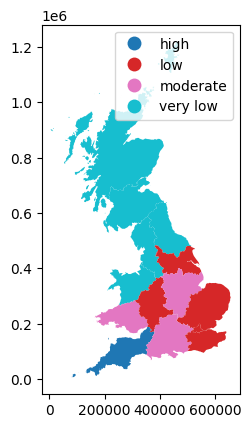

In [14]:
uk_regions_to_plot_df.plot(column="carbon_intensity_index", legend=True)

plotting map


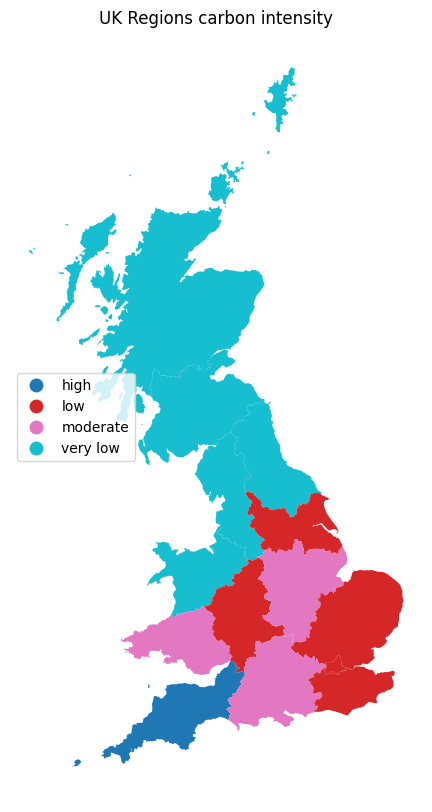

In [15]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6,10))

print("plotting map")
# Plot the map
uk_regions_to_plot_df.plot(ax=ax, column="carbon_intensity_index", legend=True, legend_kwds={"loc" : "center left"})

# Remove axis
ax.axis('off')

# Add a title
plt.title('UK Regions carbon intensity')
# plt.legend(loc='center left')
# Display the map (optional)
plt.show()

In [16]:
def generate_geodf_with_live_data():
    #firstly get the geopandas with regions, to be completed with live data
    
    geojson_filename = "uk_dno_regions_2024.geojson"
    filepath = os.path.join(path_to_data, geojson_filename)
    uk_regions = gpd.read_file(filepath)

    #get the live data
    uk_live_df = get_api_regions_as_df()

    cols_to_drop = ["Name", "DNO","DNO_Full", "id", "api_name", "dno_region"]

    #merge them on their respective id columns
    return uk_regions.merge(uk_live_df, how="inner", left_on="ID", right_on="id").drop(columns=cols_to_drop)

carbon_regions = generate_geodf_with_live_data();

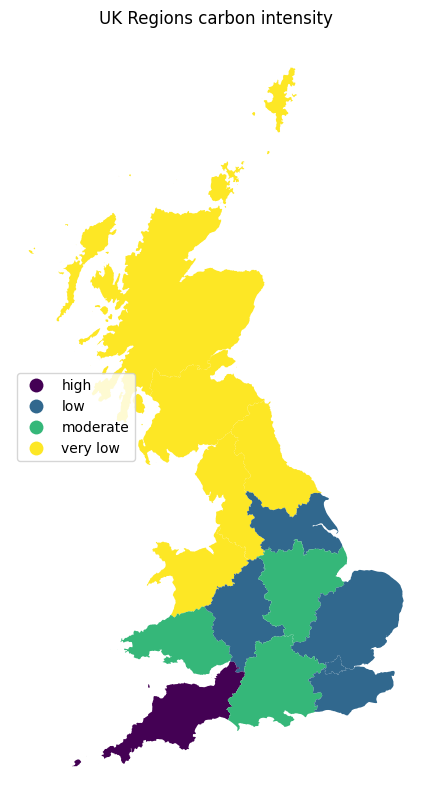

In [17]:
def carbon_intensity_plot():
    fig, ax = plt.subplots(figsize=(6,10))
    ax.axis('off')
    carbon_regions.plot(ax=ax, column="carbon_intensity_index", legend=True, legend_kwds={"loc" : "center left"}, cmap='viridis')
    plt.title('UK Regions carbon intensity')

    # plt.show()
carbon_intensity_plot()

# plotly

In [67]:
import plotly.express as px
import geopandas as gpd

df = px.data.election()
geo_df = gpd.GeoDataFrame.from_features(
    px.data.election_geojson()["features"]
).merge(df, on="district").set_index("district")

# geo_df.to_geo_dict()

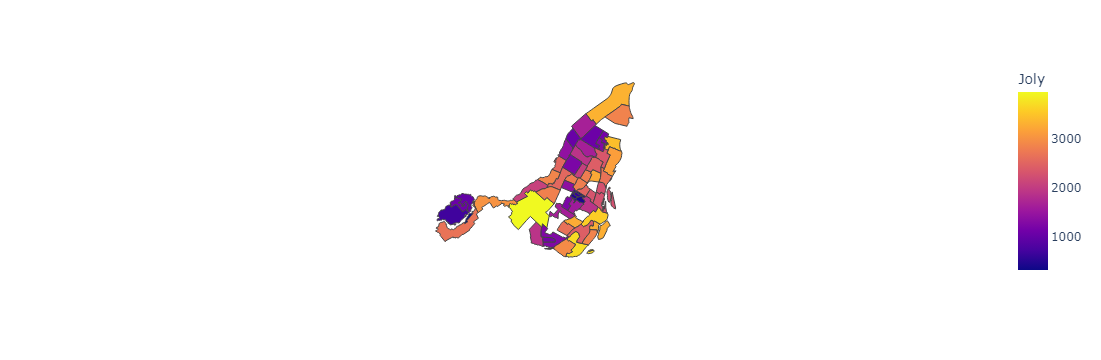

In [70]:
fig = px.choropleth(geo_df,
                   geojson=geo_df.geometry,
                   locations=geo_df.index,
                   color="Joly",
                   projection="mercator"
                   )
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [51]:
carbon_regions.to_geo_dict();

In [52]:
px.data.election()
px.data.election_geojson();


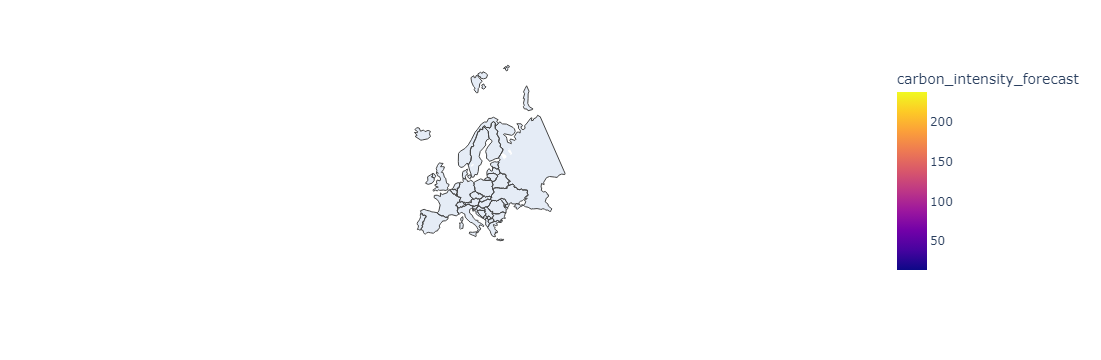

In [72]:
fig = px.choropleth(uk_live_df,
                   geojson=carbon_regions.geometry,
                    # geojson=carbon_regions.to_geo_dict(),
                    # geojson=geo_filepath,
                   locations="api_name",
                    locationmode="ISO-3",
                   color="carbon_intensity_forecast",
                    featureidkey="properties.Area",
                   # projection="mercator",
                    scope="europe",
                   )
# fig.update_geos(fitbounds="geojson", visible=True)
fig.show()

In [24]:
uk_live_df.head(3)

id                                  dno_region            api_name  \
0   1  Scottish Hydro Electric Power Distribution      North Scotland   
1   2                             SP Distribution      South Scotland   
2   3                      Electricity North West  North West England   

   carbon_intensity_forecast carbon_intensity_index  biomass_perc  coal_perc  \
0                         14               very low           0.0          0   
1                         17               very low           2.6          0   
2                         30               very low           1.4          0   

   imports_perc  gas_perc  nuclear_perc  other_perc  hydro_perc  solar_perc  \
0           0.0       3.5           0.1           0        24.8           0   
1           2.3       3.4          28.6           0         1.1           0   
2           8.2       7.0          47.1           0         0.1           0   

   wind_perc  
0       71.6  
1       62.0  
2       36.1

In [71]:
path_to_data = os.path.join("..","data","geo")
geo_file = "uk_dno_regions_2024.geojson"
geo_filepath = os.path.join(path_to_data, geo_file)
display(geo_filepath)
os.path.exists(geo_filepath)

'../data/geo/uk_dno_regions_2024.geojson'

True